# Standard Bandit

### Stationary

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])

class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class EXP3:
    def __init__(self, num_arms, gamma):
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        self.t = 1

    def select_arm(self):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)

    def update(self, arm, reward):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)
        self.t += 1

def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []
    optimal_reward = max(env.reward_means)

    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        regret = optimal_reward - reward
        regrets.append(regret)

    return np.cumsum(regrets)

# Experimental setup
num_arms = 10
reward_means = np.linspace(0, 1, num_arms)
env = BanditEnvironment(num_arms, reward_means)
num_steps = 10000

# Run experiments
plt.figure(figsize=(10, 5))

# UCB experiment
ucb_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, env, num_steps)
plt.plot(ucb_regret, label='UCB (c=2)')

# EXP3 experiment
exp3_regret = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, env, num_steps)
plt.plot(exp3_regret, label='EXP3 (γ=0.1)')

plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("UCB vs EXP3 Performance Comparison")
plt.show()

### Dynamic(random)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])

class DynamicBanditEnvironment(BanditEnvironment):
    def __init__(self, num_arms, reward_means, volatility=0.01):
        super().__init__(num_arms, reward_means)
        self.volatility = volatility

    def pull_arm(self, arm):
        reward = super().pull_arm(arm)  # Get reward first
        # Update means with random walk
        self.reward_means += np.random.normal(0, self.volatility, self.num_arms)
        self.reward_means = np.clip(self.reward_means, 0, 1)
        return reward

class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class EXP3:
    def __init__(self, num_arms, gamma):
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        self.t = 1

    def select_arm(self):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)

    def update(self, arm, reward):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)
        self.t += 1

def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []

    for _ in range(num_steps):
        current_optimal = max(env.reward_means)  # Get current optimal before pull
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        regret = current_optimal - reward
        regrets.append(regret)
        bandit.update(arm, reward)

    return np.cumsum(regrets)

# Experimental setup
num_arms = 10
base_reward_means = np.linspace(0, 1, num_arms)
num_steps = 20000

# Create environments
static_env = BanditEnvironment(num_arms, base_reward_means.copy())
dynamic_env = DynamicBanditEnvironment(num_arms, base_reward_means.copy(), volatility=0.01)

# Run experiments
plt.figure(figsize=(12, 6))

# Static Environment
plt.subplot(1, 2, 1)
ucb_static = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, static_env, num_steps)
exp3_static = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, static_env, num_steps)
plt.plot(ucb_static, label='UCB (Static)')
plt.plot(exp3_static, label='EXP3 (Static)')
plt.title("Static Environment")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

# Dynamic Environment
plt.subplot(1, 2, 2)
ucb_dynamic = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, dynamic_env, num_steps)
exp3_dynamic = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, dynamic_env, num_steps)
plt.plot(ucb_dynamic, label='UCB (Dynamic)')
plt.plot(exp3_dynamic, label='EXP3 (Dynamic)')
plt.title("Dynamic Environment")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.tight_layout()
plt.show()

### Dynamic(shuffle after fixed steps)

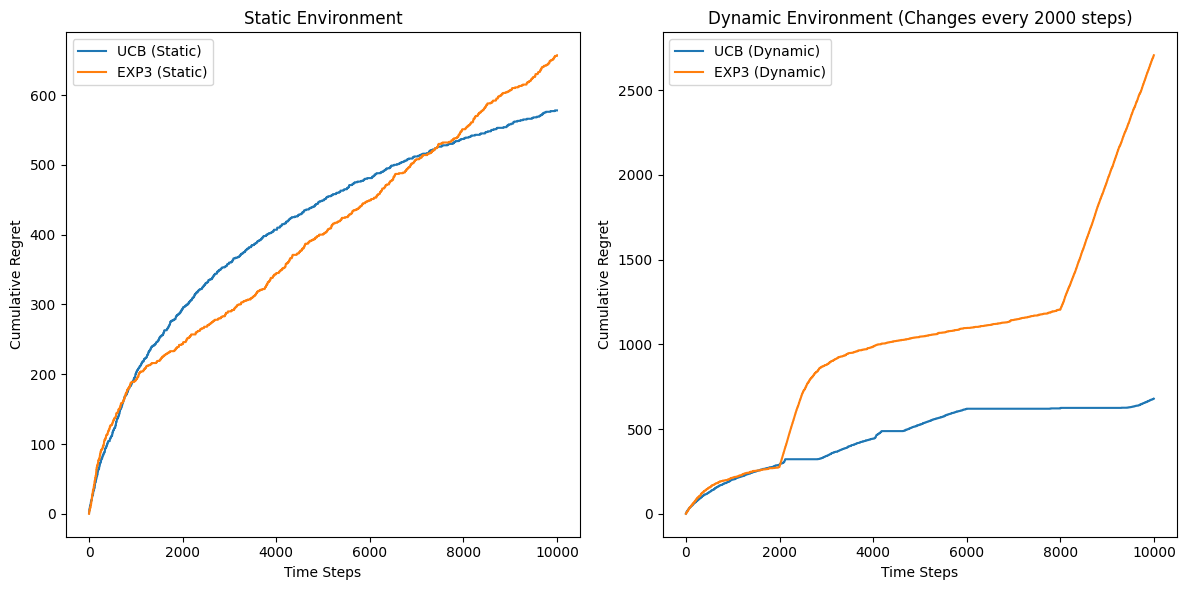

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])

class DynamicBanditEnvironment(BanditEnvironment):
    def __init__(self, num_arms, reward_means, change_interval=2000):
        super().__init__(num_arms, reward_means.copy())
        self.change_interval = change_interval
        self.time_step = 0
        self.original_means = reward_means.copy()

    def pull_arm(self, arm):
        self.time_step += 1
        if self.time_step % self.change_interval == 0:
            # Shuffle the reward means to abruptly change optimal arm
            np.random.shuffle(self.reward_means)
        return super().pull_arm(arm)

class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class EXP3:
    def __init__(self, num_arms, gamma):
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        self.t = 1

    def select_arm(self):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)

    def update(self, arm, reward):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)
        self.t += 1

def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []

    for _ in range(num_steps):
        current_optimal = max(env.reward_means)
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        regret = current_optimal - reward
        regrets.append(regret)
        bandit.update(arm, reward)

    return np.cumsum(regrets)

# Experimental setup
num_arms = 10
base_reward_means = np.linspace(0, 1, num_arms)
num_steps = 10000

# Create environments
static_env = BanditEnvironment(num_arms, base_reward_means.copy())
dynamic_env = DynamicBanditEnvironment(num_arms, base_reward_means.copy(), change_interval=2000)

# Run experiments
plt.figure(figsize=(12, 6))

# Static Environment
plt.subplot(1, 2, 1)
ucb_static = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, static_env, num_steps)
exp3_static = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, static_env, num_steps)
plt.plot(ucb_static, label='UCB (Static)')
plt.plot(exp3_static, label='EXP3 (Static)')
plt.title("Static Environment")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

# Dynamic Environment
plt.subplot(1, 2, 2)
ucb_dynamic = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, dynamic_env, num_steps)
exp3_dynamic = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, dynamic_env, num_steps)
plt.plot(ucb_dynamic, label='UCB (Dynamic)')
plt.plot(exp3_dynamic, label='EXP3 (Dynamic)')
plt.title("Dynamic Environment (Changes every 2000 steps)")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.tight_layout()
plt.show()

### Adversarial 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])

class AdversarialBanditEnvironment(BanditEnvironment):
    def __init__(self, num_arms, base_reward=0.7, attack_strength=0.02):
        """
        Adversarial environment that actively penalizes successful arms
        Args:
            base_reward: Initial reward probability for all arms
            attack_strength: How much to reduce reward when an arm is pulled
        """
        super().__init__(num_arms, np.full(num_arms, base_reward))
        self.base_reward = base_reward
        self.attack_strength = attack_strength
        self.pull_counts = np.zeros(num_arms)

    def pull_arm(self, arm):
        # Calculate reward before updating probabilities
        reward = super().pull_arm(arm)
        
        # Adversarial update rule:
        self.pull_counts[arm] += 1
        # Reduce reward probability for pulled arm
        self.reward_means[arm] = max(0, self.reward_means[arm] - self.attack_strength)
        # Gradually restore other arms' probabilities toward base reward
        for a in range(self.num_arms):
            if a != arm:
                self.reward_means[a] = min(
                    self.base_reward,
                    self.reward_means[a] + self.attack_strength/(self.num_arms-1)
                )
        return reward

class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class EXP3:
    def __init__(self, num_arms, gamma):
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        self.t = 1

    def select_arm(self):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)

    def update(self, arm, reward):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)
        self.t += 1

def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []

    for _ in range(num_steps):
        current_optimal = max(env.reward_means)
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        regret = current_optimal - reward
        regrets.append(regret)
        bandit.update(arm, reward)

    return np.cumsum(regrets)

# Experimental setup
num_arms = 10
num_steps = 10000

# Create environments
static_env = BanditEnvironment(num_arms, np.full(num_arms, 0.7))
adv_env = AdversarialBanditEnvironment(num_arms, base_reward=0.7, attack_strength=0.02)

# Run experiments
plt.figure(figsize=(12, 6))

# Static Environment
plt.subplot(1, 2, 1)
ucb_static = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, static_env, num_steps)
exp3_static = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, static_env, num_steps)
plt.plot(ucb_static, label='UCB (Static)')
plt.plot(exp3_static, label='EXP3 (Static)')
plt.title("Static Environment (All arms p=0.7)")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

# Adversarial Environment
plt.subplot(1, 2, 2)
ucb_adv = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, adv_env, num_steps)
exp3_adv = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, adv_env, num_steps)
plt.plot(ucb_adv, label='UCB (Adversarial)')
plt.plot(exp3_adv, label='EXP3 (Adversarial)')
plt.title("Adversarial Environment")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.tight_layout()
plt.show()

### Adversarial 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        """
        Standard multi-armed bandit environment where each arm has a fixed probability of providing a reward.
        :param num_arms: Number of arms in the bandit environment
        :param reward_means: Array of reward probabilities for each arm
        """
        self.num_arms = num_arms
        self.reward_means = np.array(reward_means)
    
    def pull_arm(self, arm):
        """
        Pulls the specified arm and returns a reward (1 or 0) based on its probability.
        :param arm: The selected arm
        :return: Reward (1 if successful, 0 otherwise)
        """
        return np.random.binomial(1, self.reward_means[arm])

class AdversarialBanditEnvironment(BanditEnvironment):
    def __init__(self, num_arms, base_reward=0.7, attack_strength=0.02):
        """
        Adversarial environment that reduces the reward probability of frequently chosen arms.
        :param num_arms: Number of arms
        :param base_reward: Initial reward probability for all arms
        :param attack_strength: Penalty applied to pulled arms
        """
        super().__init__(num_arms, np.full(num_arms, base_reward))
        self.base_reward = base_reward
        self.attack_strength = attack_strength
        self.pull_counts = np.zeros(num_arms)

    def pull_arm(self, arm):
        reward = super().pull_arm(arm)  # Get reward before modifying probabilities
        self.pull_counts[arm] += 1
        
        # Reduce the reward probability of the pulled arm
        self.reward_means[arm] = max(0, self.reward_means[arm] - self.attack_strength)
        
        # Gradually restore other arms' probabilities toward base reward
        for a in range(self.num_arms):
            if a != arm:
                self.reward_means[a] = min(self.base_reward, self.reward_means[a] + self.attack_strength/(self.num_arms-1))
        
        return reward

class UCB:
    def __init__(self, num_arms, c):
        """
        Upper Confidence Bound (UCB) algorithm for multi-armed bandits.
        :param num_arms: Number of arms
        :param c: Exploration parameter
        """
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)  # Number of times each arm was selected
        self.values = np.zeros(num_arms)  # Estimated values of each arm
        self.t = 1  # Time step

    def select_arm(self):
        """
        Selects the arm using the UCB formula, ensuring unselected arms are picked first.
        :return: Index of the selected arm
        """
        ucb_values = np.where(
            self.counts == 0,  # If arm has never been selected, assign infinity
            np.inf,
            self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        )
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        """
        Updates the estimated value of the selected arm.
        :param arm: The selected arm
        :param reward: The received reward
        """
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class EXP3:
    def __init__(self, num_arms, gamma):
        """
        Exponential-weighted Exploration and Exploitation (EXP3) algorithm.
        :param num_arms: Number of arms
        :param gamma: Exploration parameter
        """
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        self.t = 1

    def select_arm(self):
        """
        Selects an arm based on probability distribution derived from weights.
        :return: Index of the selected arm
        """
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)

    def update(self, arm, reward):
        """
        Updates the weights of the selected arm.
        :param arm: The selected arm
        :param reward: The received reward
        """
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)
        self.weights /= np.sum(self.weights)  # Normalize weights to prevent overflow
        self.t += 1

def run_experiment(bandit_class, bandit_params, env, num_steps):
    """
    Runs the bandit experiment for a given algorithm and environment.
    :param bandit_class: The bandit algorithm class (UCB or EXP3)
    :param bandit_params: Parameters for the bandit algorithm
    :param env: The environment (static or adversarial)
    :param num_steps: Number of time steps
    :return: Cumulative regret over time
    """
    bandit = bandit_class(**bandit_params)
    regrets = []
    
    for _ in range(num_steps):
        current_optimal = max(env.reward_means)
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        regret = current_optimal - reward
        regrets.append(regret)
        bandit.update(arm, reward)
    
    return np.cumsum(regrets)

# Experimental setup
num_arms = 10
num_steps = 10000

# Create environments
static_env = BanditEnvironment(num_arms, np.full(num_arms, 0.7))
adv_env = AdversarialBanditEnvironment(num_arms, base_reward=0.7, attack_strength=0.02)

# Run experiments and plot results
plt.figure(figsize=(12, 6))

# Static Environment
plt.subplot(1, 2, 1)
ucb_static = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, static_env, num_steps)
exp3_static = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, static_env, num_steps)
plt.plot(ucb_static, label='UCB (Static)')
plt.plot(exp3_static, label='EXP3 (Static)')
plt.title("Static Environment (All arms p=0.7)")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

# Adversarial Environment
plt.subplot(1, 2, 2)
ucb_adv = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, adv_env, num_steps)
exp3_adv = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, adv_env, num_steps)
plt.plot(ucb_adv, label='UCB (Adversarial)')
plt.plot(exp3_adv, label='EXP3 (Adversarial)')
plt.title("Adversarial Environment")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.tight_layout()
plt.show()
